## Classification Model to predict level of damage caused by earthquake
This notebook analyzes the data of damage to buildings caused by 2015 Nepal earthquake. 

Here are steps followed to build the predictive model to estimate the extent of damage to buildings

1.Data exploration of all features by calculating summary and descriptive statistics and also generating the visualization

2.Preparing data for machine learning by normalizing & binning of numerical features and  encoding the catergorical features

3.Exploring different algorithms to understand best fitting algorithm for given dataset

4.Hypertuning the parameters to get better accuracy

In [4]:
# Import the essential libraries, more libraries will be imported later as needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
#Get the data into a dataframe 
X = pd.read_csv(r"..\edx-Capstone\train_values.csv", index_col = ["building_id"] )
y = pd.read_csv(r"..\edx-Capstone\train_labels.csv", index_col = ["building_id"] )


In [6]:
#Quick Check to see if data needs any cleansing
X.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area,height,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
765,8,501,3237,2,25,33,4,d502,337f,7e76,...,0,0,0,0,0,0,0,0,0,0
9470,7,288,1819,3,15,28,5,d502,337f,7e76,...,0,0,0,0,0,0,0,0,0,0
14461,14,36,838,1,20,37,2,d502,337f,7e76,...,0,1,0,0,0,0,0,0,0,0
9317,8,81,805,2,5,18,3,d502,337f,7e76,...,0,0,0,0,0,0,0,0,0,0
15941,23,380,4266,3,0,39,6,d502,337f,7e76,...,0,0,0,0,0,0,0,0,0,0


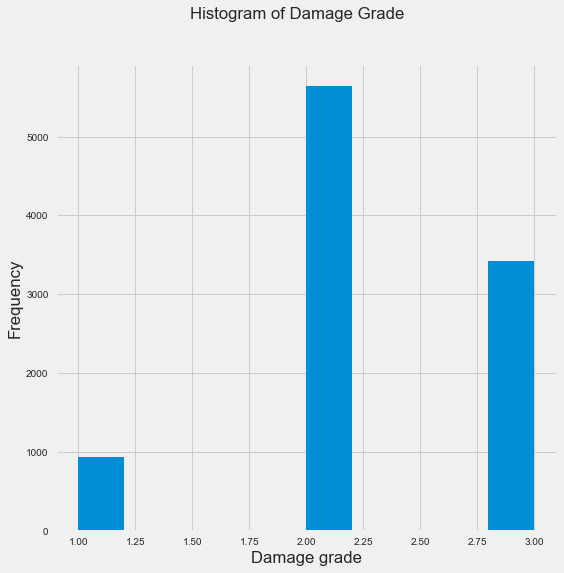

In [7]:
# Distribution of target (damage_grade) values
fig = plt.figure(figsize = (8,8))
fig.suptitle('Histogram of Damage Grade')
ax = fig.add_subplot(111)
plt.hist(y.damage_grade)
plt.xlabel("Damage grade")
plt.ylabel("Frequency")
plt.show()

#y.damage_grade.plot.hist(alpha = 0.5)

In [ ]:
#Join Predictors with target for exploring relationship between various predictors to target
raw = X.join(y)

# Numerical Features exploration

In [9]:
# Get summary statistics for numerical features
raw[['count_floors_pre_eq', 'age', 'area', 'height', 'count_families']].describe()

,count_floors_pre_eq,age,area,height,count_families
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.146700,25.393500,38.438100,4.653100,0.984600
std,0.736365,64.482893,21.265883,1.792842,0.423297
min,1.000000,0.000000,6.000000,1.000000,0.000000
25%,2.000000,10.000000,26.000000,4.000000,1.000000
50%,2.000000,15.000000,34.000000,5.000000,1.000000
75%,3.000000,30.000000,44.000000,5.000000,1.000000
max,9.000000,995.000000,425.000000,30.000000,7.000000


In [10]:
# Get distinct count 
raw[['count_floors_pre_eq', 'age', 'area', 'height', 'count_families']].nunique()

count_floors_pre_eq      8
age                     31
area                   158
height                  18
count_families           8
dtype: int64

In [12]:

raw[raw.age > 200]['age'].value_counts()

995    40
Name: age, dtype: int64

In [13]:
# There are no values between 200 and 995, I believe 995 is code for unknown. 
# So replacing 995 with mean of the age
raw['age'] = raw.age.apply(lambda x : 25 if x == 995 else x)

In [14]:
# mean of numerical features by damage grade
raw[['damage_grade','count_floors_pre_eq', 'age', 'area', 'height', 'count_families']].groupby(['damage_grade']).mean()

,count_floors_pre_eq,age,area,height,count_families
damage_grade,,,,,
1,1.860341,10.565032,46.320896,4.415778,0.929638
2,2.152236,22.146026,38.464336,4.670334,0.982434
3,2.215995,23.470520,36.236719,4.689726,1.003211


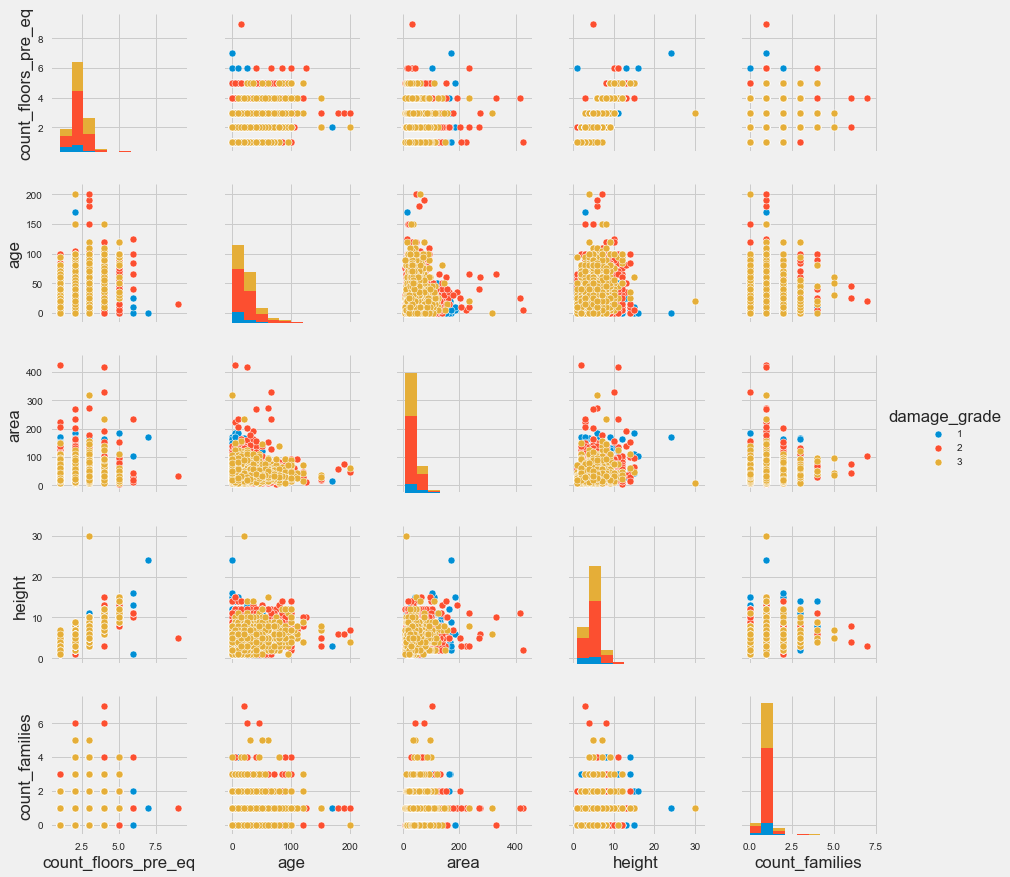

In [15]:
# Pairplot to capture any correlation between numerical features, colorcoded with damage grade
numcols = ['count_floors_pre_eq', 'age', 'area', 'height','count_families','damage_grade']

plt.figure()
sns.pairplot(data = raw[numcols], hue = "damage_grade", 
             vars =['count_floors_pre_eq', 'age', 'area', 'height','count_families'])
plt.savefig("1_seaborn_pair_plot.png")

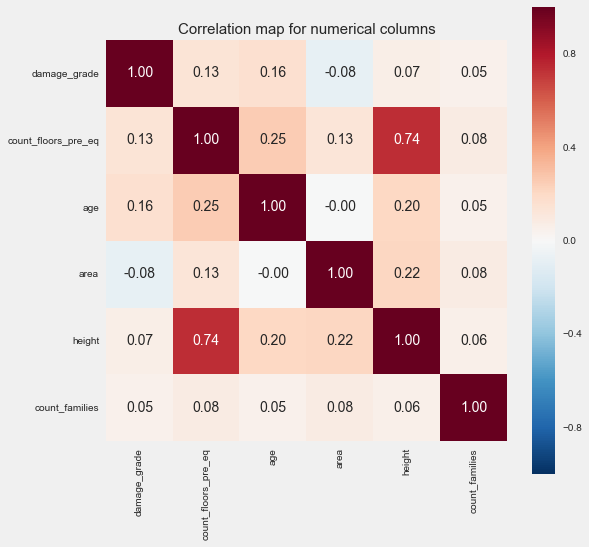

In [16]:
# Correlation matrix of numerical columns along with target in heatmap  
corrmat2 = raw[['damage_grade','count_floors_pre_eq', 'age', 'area', 'height', 'count_families']].corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat2, vmax=1.0, square=True, annot=True, fmt=".2f")
plt.title("Correlation map for numerical columns", fontsize=15)
plt.show()

In [17]:
## Function to plot conditioned histograms
def cond_hists(df, plot_cols, grid_col):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ## Loop over the list of columns
    for col in plot_cols:
        grid1 = sns.FacetGrid(df, col=grid_col)
        grid1.map(plt.hist, col, alpha=.7)
    return grid_col

'damage_grade'

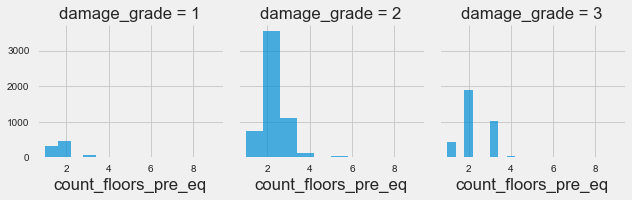

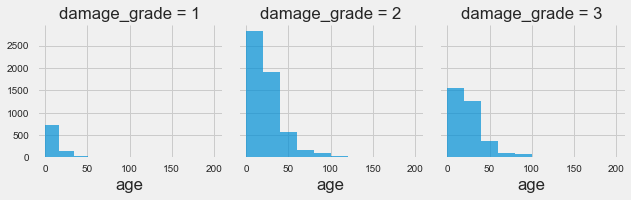

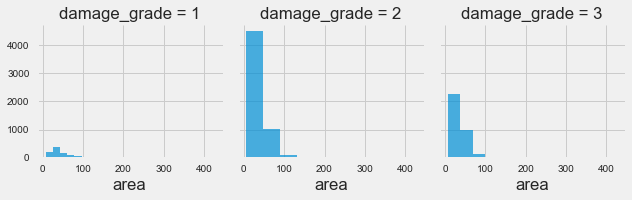

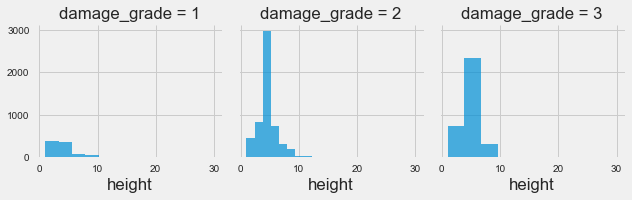

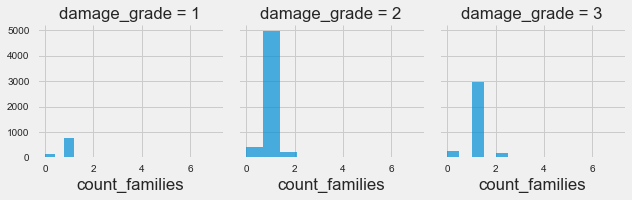

In [18]:
# Visualize the conditioned histogram of numerical columns
#plt.style.use('ggplot')
cols = ['count_floors_pre_eq', 'age', 'area', 'height', 'count_families']
cond_hists(raw, cols, 'damage_grade')

In [19]:
# function to generate Conditioned Boxplot
def plt_box(df, cols):
#import matplotlib.pyplot as plt
## Loop over the columns and create the box plots
    for col in cols:
        fig = plt.figure(figsize=(8, 6))
        fig.clf()
        ax = fig.gca()
        df.boxplot(column = col , by = 'damage_grade', ax = ax)
        ax.set_ylabel(col)
        ax.set_xlabel('damage_grade')
        ax.set_title(col + ' vs Damage Grade ')
    return 'Done'

'Done'

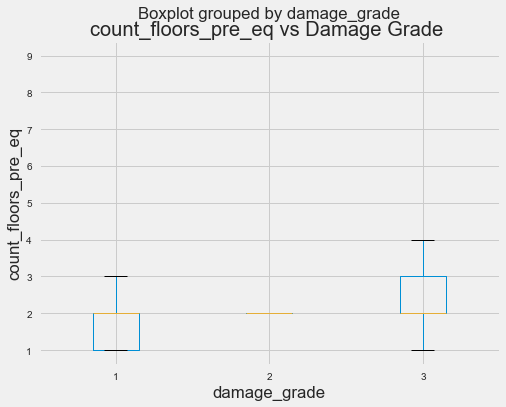

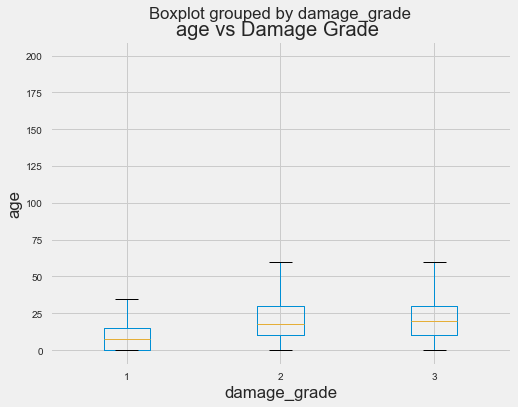

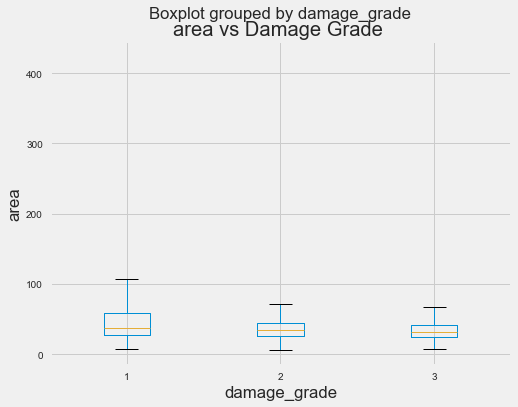

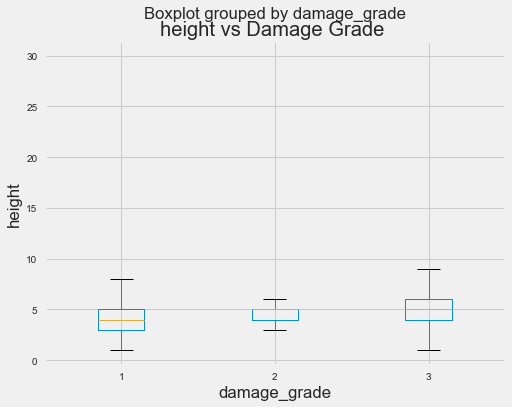

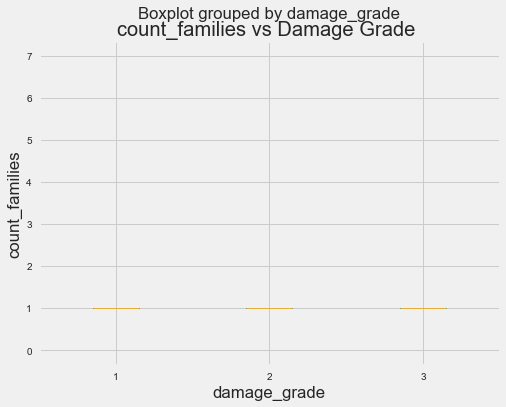

In [20]:
#capture interquartile range by damage grade using boxplot 
plt_box(raw,cols)

damage_grade    1     2     3
age_bins                     
0-10          633  2015  1096
10-20         181  1500   928
20-30          81   999   647
30-40          26   444   310
40 to end      17   678   445


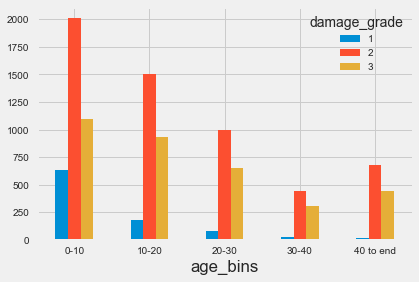

In [21]:
# capture Age into 5 bins to understand the distribution
bins = [0,10,20,30,40,995]
raw['age_bins'] = pd.cut(raw['age'],bins, labels = ['0-10','10-20','20-30','30-40','40 to end'],include_lowest=True)
age_bin_pivot = pd.pivot_table(raw,values = 'age',index=['age_bins'], columns=['damage_grade'], aggfunc= np.size)
print(age_bin_pivot)

age_bin_pivot.plot.bar(rot=0)

damage_grade      1       2       3
height_bins                        
0-2           186.0   470.0   280.0
02-04         361.0  2203.0  1241.0
04-05         200.0  1604.0  1016.0
05-06          76.0   743.0   536.0
06-08          51.0   441.0   285.0
08-12          53.0   165.0    64.0
12-18          10.0    10.0     3.0
18-30           1.0     NaN     1.0


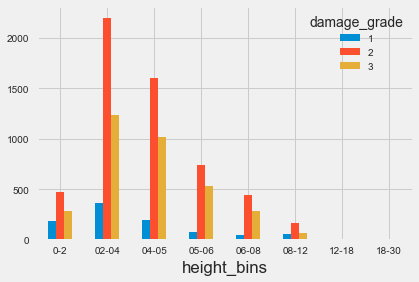

In [22]:
# similary capture height bins
bins = [0,2,4,5,6,8,12,18,30]
ht_labels = ['0-2','02-04','04-05', '05-06', '06-08', '08-12', '12-18', '18-30']
raw['height_bins'] = pd.cut(raw['height'],bins ,labels = ht_labels, include_lowest=True)

height_bin_pivot = pd.pivot_table(raw,values = 'height',index=['height_bins'], columns=['damage_grade'], aggfunc= np.size)

print(height_bin_pivot)

height_bin_pivot.plot.bar(rot =0)

In [23]:
# explore Geo features, get summary statistics
#raw[['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']].describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id
count,10000.000000,10000.000000,10000.000000
mean,7.135600,296.930300,2678.617900
std,6.225567,279.390651,2520.663769
min,0.000000,0.000000,0.000000
25%,2.000000,60.000000,606.750000
50%,6.000000,219.000000,1937.500000
75%,10.000000,466.000000,4158.000000
max,30.000000,1411.000000,12151.000000


In [24]:
# Get distinct counts
#raw[['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']].nunique()

geo_level_1_id      31
geo_level_2_id    1137
geo_level_3_id    5172
dtype: int64

In [25]:
# Get Mean of Geo levels by damage grade
raw[['geo_level_1_id', 'geo_level_2_id','geo_level_3_id']].groupby(raw['damage_grade']).mean()

,geo_level_1_id,geo_level_2_id,geo_level_3_id
damage_grade,,,
1,6.615139,240.314499,2132.597015
2,7.742016,317.641057,2876.788857
3,6.280502,278.360479,2502.107706


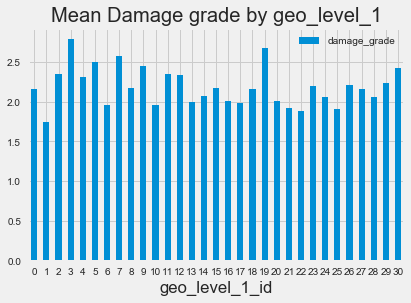

In [26]:
# plot Mean damage grade by geo_level_1 to understand which geo_level_1 position has more damage 
raw[['damage_grade']].groupby(raw['geo_level_1_id']).mean().plot.bar(rot=0,  legend = True,
                                                                 title = 'Mean Damage grade by geo_level_1')

# Catgorical feature exploration

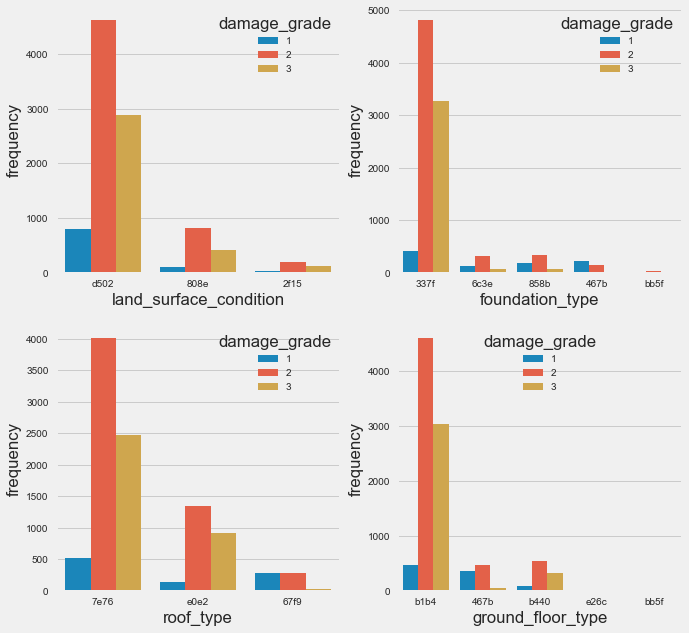

In [27]:
# explore Categorical Features
cat_cols = ['land_surface_condition','foundation_type', 'roof_type', 'ground_floor_type']


fig = plt.figure(figsize = (10,10))
for i in range(len(cat_cols)):
    ax = sns.countplot(x=cat_cols[i], hue = 'damage_grade', data = raw, ax = plt.subplot(221+i))
    plt.xlabel(cat_cols[i])
    plt.ylabel('frequency')
    

    #sns.FacetGrid(raw, hue='damage_grade')
    #grid1.map(sns.countplot, col, alpha=.7)


In [28]:
#get summary statistics
raw[cat_cols].describe()

,land_surface_condition,foundation_type,roof_type,ground_floor_type
count,10000,10000,10000,10000
unique,3,5,3,5
top,d502,337f,7e76,b1b4
freq,8311,8489,7007,8118


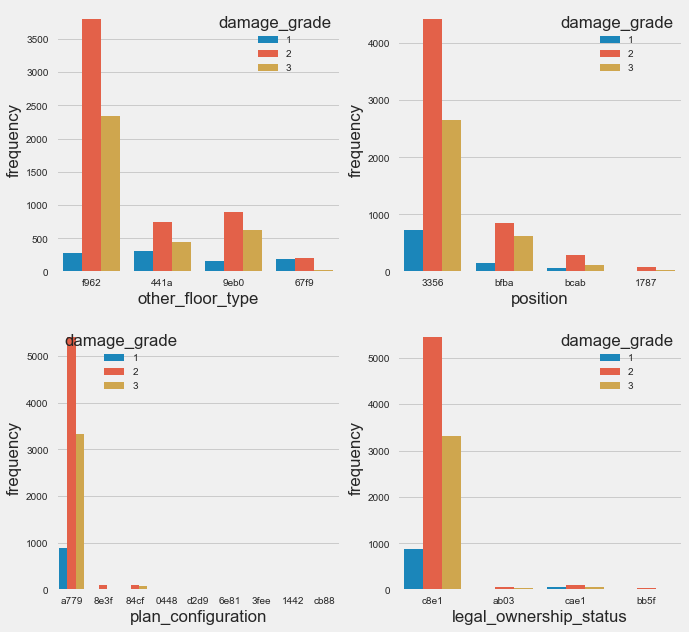

In [29]:
# explore second set of catgorical features
cat_cols2 = ['other_floor_type','position', 'plan_configuration', 'legal_ownership_status']

fig = plt.figure(figsize = (10,10))
for i in range(len(cat_cols2)):
    ax = sns.countplot(x=cat_cols2[i], hue = 'damage_grade', data = raw, ax = plt.subplot(221+i))
    plt.xlabel(cat_cols2[i])
    plt.ylabel('frequency')

In [30]:
#raw[cat_cols2].describe()

,other_floor_type,position,plan_configuration,legal_ownership_status
count,10000,10000,10000,10000
unique,4,4,9,4
top,f962,3356,a779,c8e1
freq,6412,7792,9603,9627


# Binary feature exploration

In [31]:
# Get Mean value of Binary features 
col_sec_use = ['has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

print(raw[col_sec_use].mean())


has_secondary_use                0.1086
has_secondary_use_agriculture    0.0673
has_secondary_use_hotel          0.0294
has_secondary_use_rental         0.0064
has_secondary_use_institution    0.0007
has_secondary_use_school         0.0007
has_secondary_use_industry       0.0008
has_secondary_use_health_post    0.0002
has_secondary_use_gov_office     0.0002
has_secondary_use_use_police     0.0001
has_secondary_use_other          0.0053
dtype: float64


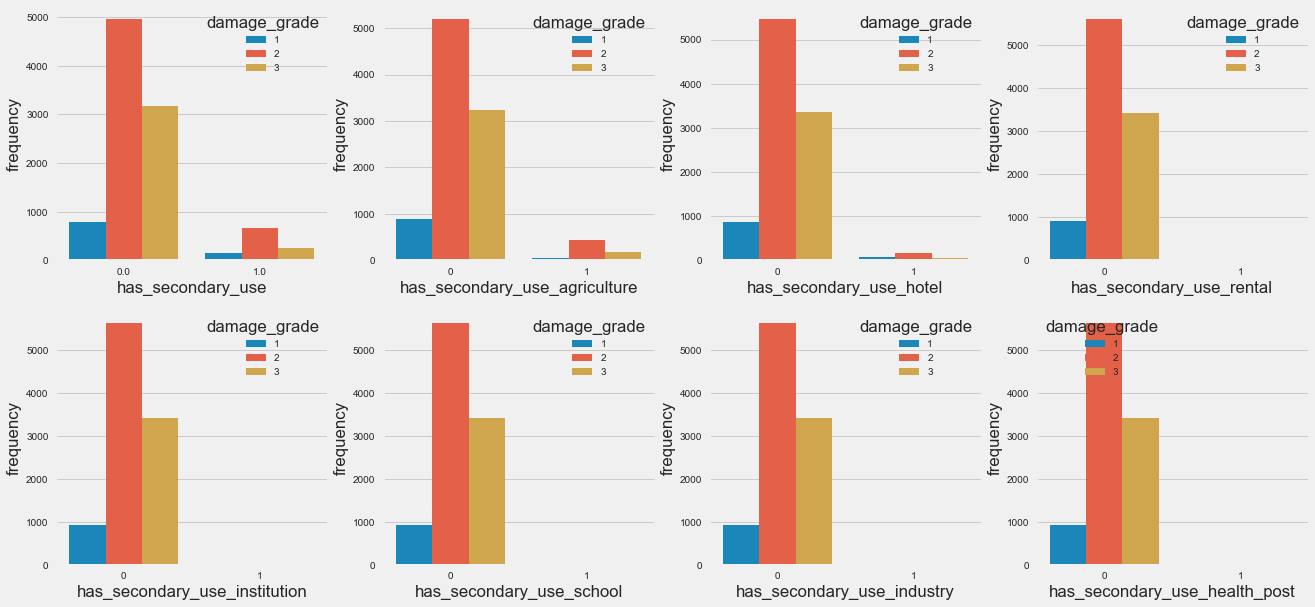

In [32]:
# Plot binary features to get the distribution

fig = plt.figure(figsize = (20,20))
for i in range(8):
    ax = sns.countplot(x=col_sec_use[i], hue = 'damage_grade', data = raw, ax = plt.subplot(441+i))
    plt.xlabel(col_sec_use[i])
    plt.ylabel('frequency')

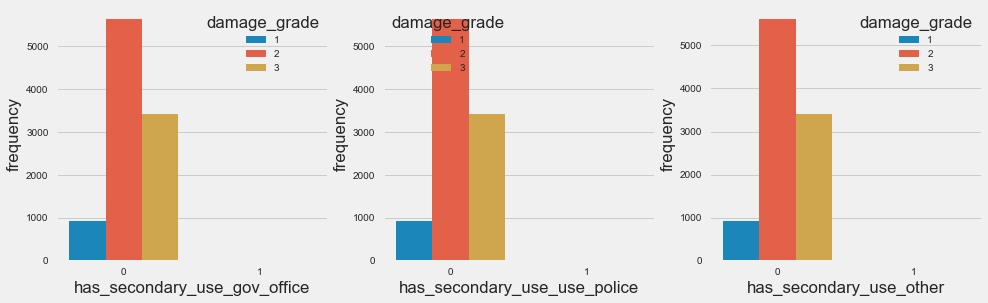

In [33]:
fig = plt.figure(figsize = (20,20))
for i in range(3):
    ax = sns.countplot(x=col_sec_use[i+8], hue = 'damage_grade', data = raw, ax = plt.subplot(441+i))
    plt.xlabel(col_sec_use[i+8])
    plt.ylabel('frequency')

In [34]:
supstrc_cols = ['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

print(raw[supstrc_cols].mean())

has_superstructure_adobe_mud              0.0897
has_superstructure_mud_mortar_stone       0.7626
has_superstructure_stone_flag             0.0299
has_superstructure_cement_mortar_stone    0.0190
has_superstructure_mud_mortar_brick       0.0688
has_superstructure_cement_mortar_brick    0.0725
has_superstructure_timber                 0.2561
has_superstructure_bamboo                 0.0877
has_superstructure_rc_non_engineered      0.0400
has_superstructure_rc_engineered          0.0138
has_superstructure_other                  0.0141
dtype: float64


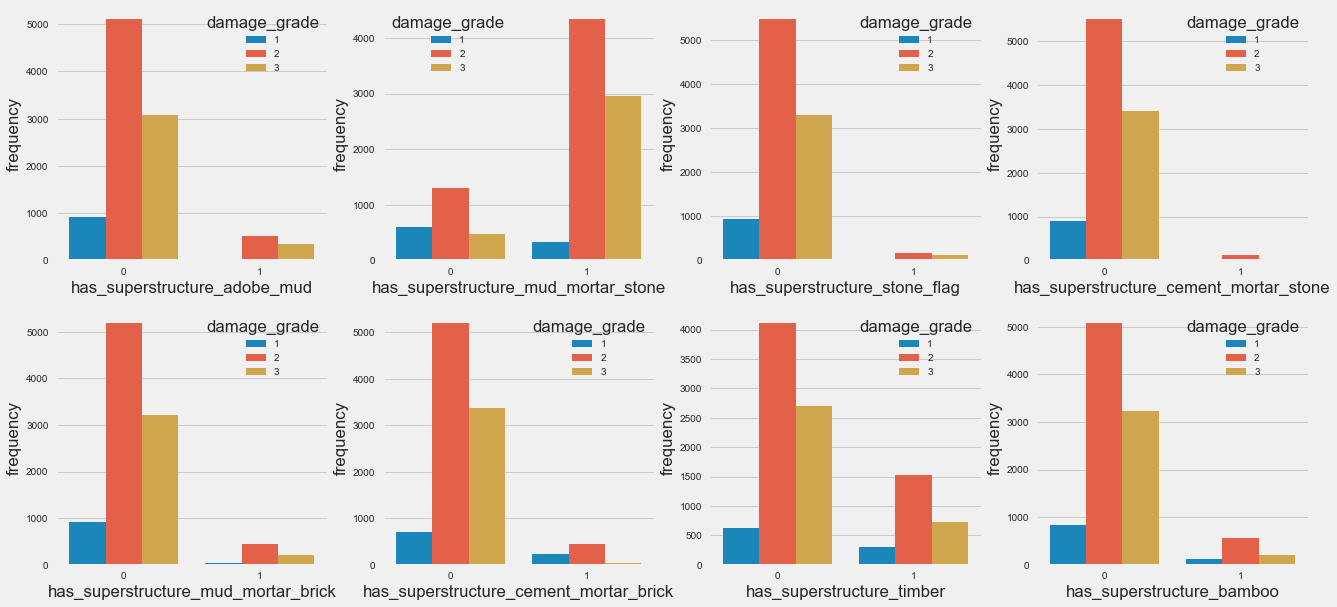

In [35]:
fig = plt.figure(figsize = (20,20))
for i in range(8):
    ax = sns.countplot(x=supstrc_cols[i], hue = 'damage_grade', data = raw, ax = plt.subplot(441+i))
    plt.xlabel(supstrc_cols[i])
    plt.ylabel('frequency')

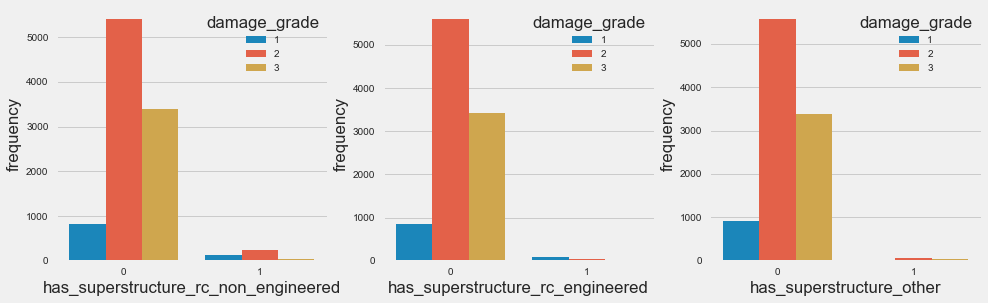

In [36]:
fig = plt.figure(figsize = (20,20))
for i in range(3):
    ax = sns.countplot(x=supstrc_cols[i+8], hue = 'damage_grade', data = raw, ax = plt.subplot(441+i))
    plt.xlabel(supstrc_cols[i+8])
    plt.ylabel('frequency')

#  Prepare data for Machine Learning

In [39]:
#import sklearn and scikit libraries for the algorithms
import os
import warnings
warnings.filterwarnings('ignore')
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
warnings.filterwarnings('ignore')
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
warnings.filterwarnings('ignore')

In [40]:
#replace 995 with mean of the age
X['age'] = X.age.apply(lambda x : 25 if x == 995 else x)

In [41]:
# Add age and height bins 
bins = [0,10,20,30,40,995]
X['age_bins'] = pd.cut(X['age'],bins, labels = [1,2,3,4,5],include_lowest=True)

bins = [0,2,4,5,6,8,12,18,30]
ht_labels = [1,2,3, 4, 5, 6,7, 8]
X['height_bins'] = pd.cut(X['height'],bins ,labels = ht_labels, include_lowest=True)

In [42]:
# Use get_dummies function to transform catergorical features into binary indicator values
X_prep = pd.get_dummies(X, columns = ['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position','plan_configuration', 'legal_ownership_status','age_bins', 'height_bins'])

In [43]:
# Normalize the numerical features using MinMax Scaler so that we can rescale it
numcols = ['count_floors_pre_eq', 'age', 'area', 'height','count_families']

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_prep[numcols] = pd.DataFrame(min_max_scaler.fit_transform(X_prep[numcols]), columns=numcols, index=X_prep.index)

In [44]:
# Split data into training and test data sets, the ratio we are using 75% training and 25% test
from sklearn.model_selection import train_test_split
y1 = y.damage_grade # to get rid of index
X_train, X_test,y_train, y_test = train_test_split(X_prep, y1, test_size = 0.25, random_state = 7)

# Evaluate different algorithms

In [45]:
# Compare different classification algorithms

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
model_list = []
model_list.append(('GradientBoosting', GradientBoostingClassifier()))
model_list.append(('RandomForestClassifier', RandomForestClassifier()))
model_list.append(('KNeighborsClassifier', KNeighborsClassifier(n_neighbors = 15)))
model_list.append(('MultiClass Logistic Regression', LogisticRegression( solver='newton-cg',multi_class = 'multinomial')))
model_list.append(('XGBoost', xgb.XGBClassifier(learning_rate =0.1,n_estimators=200,objective= 'multi:softmax')))

names = []
results = []

y1 = y.damage_grade

for name, model in model_list:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    scores = cross_val_score(model, X_prep, y1, cv= 10, scoring='f1_micro')
    results.append(scores)
    names.append(name)
    print("f1_score for",name, ":", f1_score(y_test, pred, average = 'micro'))
    print("Recall score for three damage grades using", name, ":",  recall_score(y_test, pred, average = None ))
    print('Mean Cross Validcation Score for', name, scores.mean())
    
    

f1_score for GradientBoosting : 0.6652
Recall score for three damage grades using GradientBoosting : [ 0.35930736  0.83927324  0.4522673 ]
Mean Cross Validcation Score for GradientBoosting 0.663406268617
f1_score for RandomForestClassifier : 0.622
Recall score for three damage grades using RandomForestClassifier : [ 0.36796537  0.78825996  0.40811456]
Mean Cross Validcation Score for RandomForestClassifier 0.614910195772
f1_score for KNeighborsClassifier : 0.5676
Recall score for three damage grades using KNeighborsClassifier : [ 0.12554113  0.80992313  0.27565632]
Mean Cross Validcation Score for KNeighborsClassifier 0.564902405784
f1_score for MultiClass Logistic Regression : 0.5944
Recall score for three damage grades using MultiClass Logistic Regression : [ 0.32900433  0.83298393  0.2601432 ]
Mean Cross Validcation Score for MultiClass Logistic Regression 0.583800137307
f1_score for XGBoost : 0.674
Recall score for three damage grades using XGBoost : [ 0.38095238  0.84765898  0.458

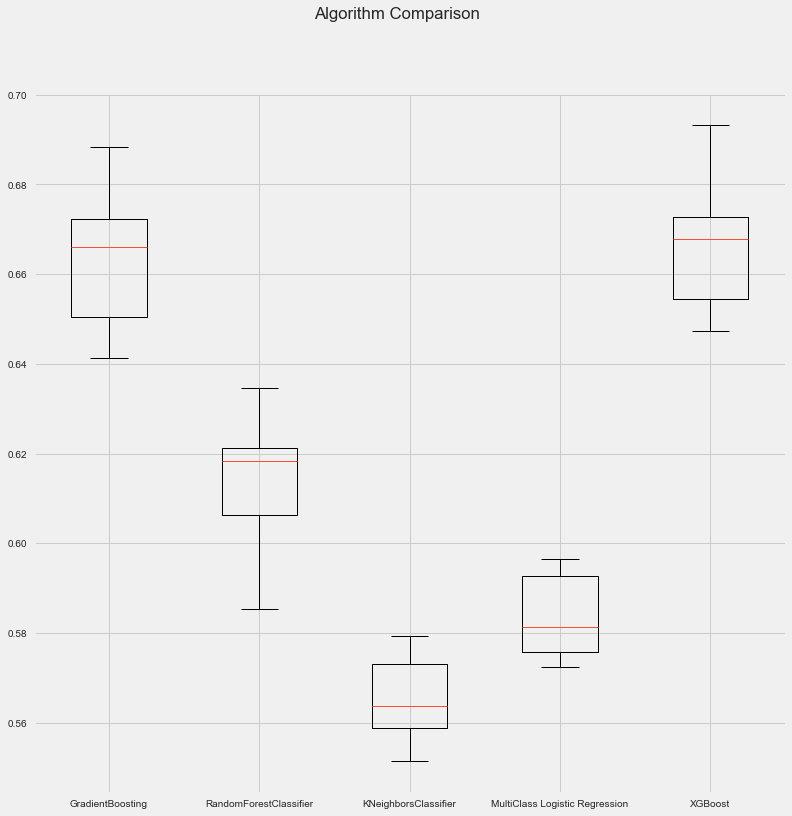

In [46]:
# Compare Algorithms using boxplots
fig = plt.figure(figsize = (12,12))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Hypertuning the algorithm parameters

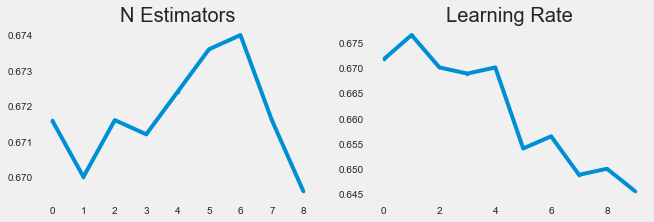

In [47]:
# first we will tune the Gradient Boosting algorithm  different values of parameters like n_estimators and learning rate
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = [240,250,260,270,280,300, 320,400, 410]
scores=[]
for feature in feature_param:
    #reg = GradientBoostingRegressor(n_estimators=feature)
    model = GradientBoostingClassifier(n_estimators =feature)
    model.fit(X_train,y_train)
    scoreCV = model.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Learning Rate
plt.subplot(3,3,2)
feature_param = np.linspace(0.1,1,10)
scores=[]
for feature in feature_param:
    model = GradientBoostingClassifier(n_estimators= 240, learning_rate=feature)
    model.fit(X_train,y_train)
    scoreCV = model.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Learning Rate')
plt.grid();

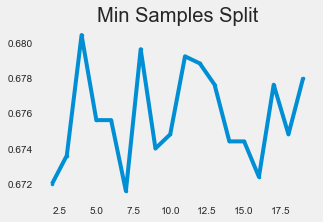

In [48]:
plt.figure(figsize=(15,10))
#Min Samples Split
plt.subplot(3,3,1)
feature_param = range(2,20)
scores=[]
for feature in feature_param:
    #reg = GradientBoostingRegressor(min_samples_split =feature)
    model = GradientBoostingClassifier(n_estimators= 280, learning_rate =0.1, min_samples_split =feature)
    model.fit(X_train,y_train)
    scoreCV = model.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

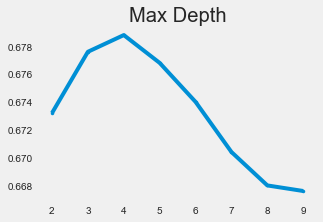

In [49]:
plt.figure(figsize=(15,10))
#Min Samples Split
plt.subplot(3,3,1)
feature_param = range(2,10)
scores=[]
for feature in feature_param:
    #reg = GradientBoostingRegressor(min_samples_split =feature)
    model = GradientBoostingClassifier(n_estimators= 320, learning_rate =0.1,min_samples_split=4, max_depth =feature)
    model.fit(X_train,y_train)
    scoreCV = model.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

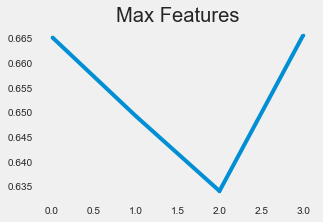

In [50]:
plt.figure(figsize=(15,10))
#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    model = GradientBoostingClassifier(max_features =feature)
    model.fit(X_train,y_train)
    scoreCV = model.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.grid();

In [52]:
#update Gradient boosting classifier with fine tuned parameters values to improve the score
gb_model = GradientBoostingClassifier(n_estimators= 320, learning_rate =0.1, min_samples_split=4, 
                                      min_samples_leaf=8, max_depth =4, max_features = 'auto', criterion='mse')


In [53]:
#perform 10 fold crossvalidation to ensure the model is not overfitted
scores = cross_val_score(gb_model, X_prep, y1, cv= 10, scoring='f1_micro')

In [67]:
# Mean F1-Score
scores.mean()

0.67770438832563085

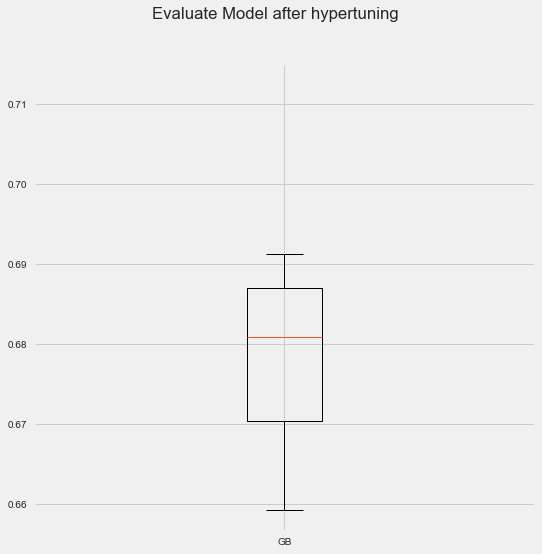

In [54]:
fig = plt.figure(figsize = (8,8))
fig.suptitle('Evaluate Model after hypertuning')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(["GB"])
plt.show()

In [76]:
#Performed Random Grid Search to see if it can improve the f1-score, didn't see any improvement 
# commented out below code as Rondom grid search takes very long time to finish
'''from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
warnings.filterwarnings('ignore')

from sklearn.grid_search import RandomizedSearchCV

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [2,3,4, None],
              "min_samples_split": sp_randint(2, 15),
              "min_samples_leaf": sp_randint(1, 11)
              }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)'''

Results

RandomizedSearchCV took 5897.10 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.669 (std: 0.007)
Parameters: {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.667 (std: 0.009)
Parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.667 (std: 0.009)
Parameters: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 6}



# Hypertuning of XGBoost Classifier 

In [55]:
# xgboost classifier parameters are tuned in pairs thru gridsearch
param_test1 = {
 'max_depth': [3,5,7,9],
 'min_child_weight': [1,3,5]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27, average='micro'), 
 param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.66374, std: 0.00715, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.65960, std: 0.00993, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.66187, std: 0.01013, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.66747, std: 0.01033, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.66947, std: 0.00945, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.67307, std: 0.00948, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.66560, std: 0.01455, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.66934, std: 0.01433, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.67427, std: 0.01653, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.67281, std: 0.01599, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.66960, std: 0.01377, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.67347, std: 0.01610, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5

In [58]:
# Updated the classifier with best parameter values for max_depth and min_child_weight. Now find the optimal values for gamma 
# and n_estimators 

param_test2 = {
 'n_estimators': [180,200,250,280,320],
 'gamma': [0.0,0.1,0.2,0.3]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27, average='micro'), 
 param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.67214, std: 0.01847, params: {'gamma': 0.0, 'n_estimators': 180},
  mean: 0.67187, std: 0.01867, params: {'gamma': 0.0, 'n_estimators': 200},
  mean: 0.66880, std: 0.01579, params: {'gamma': 0.0, 'n_estimators': 250},
  mean: 0.66720, std: 0.01597, params: {'gamma': 0.0, 'n_estimators': 280},
  mean: 0.66454, std: 0.01584, params: {'gamma': 0.0, 'n_estimators': 320},
  mean: 0.67081, std: 0.01684, params: {'gamma': 0.1, 'n_estimators': 180},
  mean: 0.67214, std: 0.01543, params: {'gamma': 0.1, 'n_estimators': 200},
  mean: 0.66934, std: 0.01442, params: {'gamma': 0.1, 'n_estimators': 250},
  mean: 0.66867, std: 0.01475, params: {'gamma': 0.1, 'n_estimators': 280},
  mean: 0.66707, std: 0.01617, params: {'gamma': 0.1, 'n_estimators': 320},
  mean: 0.66947, std: 0.01757, params: {'gamma': 0.2, 'n_estimators': 180},
  mean: 0.66801, std: 0.01897, params: {'gamma': 0.2, 'n_estimators': 200},
  mean: 0.66654, std: 0.01962, params: {'gamma': 0.2, 'n_estimators': 250},
  mean: 0.66

In [59]:
param_test3 = {
 'colsample_bytree': [0.6,0.7,0.8,0.9],
 'subsample': [0.6,0.7,0.8,0.9]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27, average='micro'), 
 param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.67227, std: 0.01467, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.67120, std: 0.01336, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.67281, std: 0.01794, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.67241, std: 0.01295, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.66921, std: 0.01482, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.66841, std: 0.01596, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.67614, std: 0.01492, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.67800, std: 0.01080, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.66707, std: 0.01526, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.66721, std: 0.01530, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.67427, std: 0.01653, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.67520, std: 0.01206, params: {'colsample_bytree': 0.8, 'subsample'

In [60]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1],
 'reg_lambda':[1e-5, 1e-2, 0.1, 1]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.7,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1, seed=27, average='micro'), 
 param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.67374, std: 0.01617, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: 0.67467, std: 0.01409, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: 0.67694, std: 0.01165, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: 0.67800, std: 0.01080, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.67481, std: 0.01379, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: 0.67294, std: 0.00946, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: 0.67614, std: 0.01078, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: 0.67801, std: 0.01313, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.67547, std: 0.01731, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: 0.67600, std: 0.01225, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: 0.67334, std: 0.01440, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1},
  mean: 0.67547, std: 0.01238, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: 0.67760, std: 0.01187, params: {'reg_alph

In [73]:
# As provided is imbalanced with most of damage grade is 2, introduced sample weightage which slightly improved f1-score
weights = np.zeros(len(y_train))
weights[y_train == 1] = 1.1
weights[y_train == 2] = 1
weights[y_train == 3] = 1.1

In [75]:
# Now apply all the tuned parameters to classifier 
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=7,
 min_child_weight=5,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'multi:softmax',
 nthread=4,
 num_class =4,
 scale_pos_weight=1,
 reg_lambda = 1,
 reg_alpha = 0.01,
 seed=27)
xgb1.fit(X_train, y_train ,sample_weight = weights, eval_metric='auc')
pred = xgb1.predict(X_test)
print(f1_score(y_test, pred, average = 'micro'))
print(recall_score(y_test, pred, average = None ))

0.678
[ 0.41558442  0.79524808  0.55011933]


In [66]:
# perform 10 fold cross validation to ensure the model is not overfitted
scores_xgb = cross_val_score(xgb1, X_prep, y1, cv= 10, scoring='f1_micro')

In [72]:
scores_xgb.mean()

0.68280339552884639

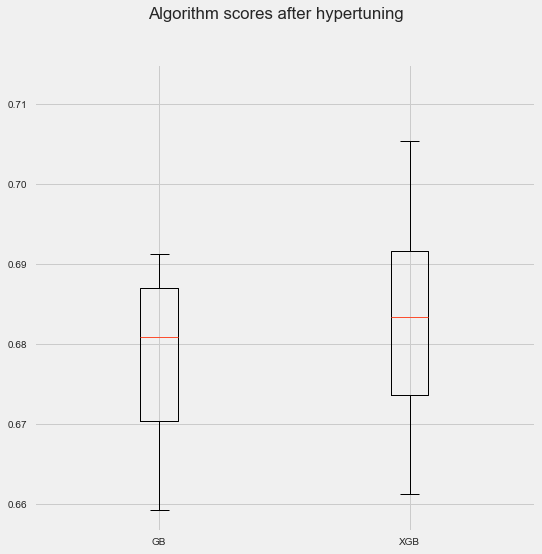

In [71]:
# compare performance of gradient boost to xgboost thru boxplot
fig = plt.figure(figsize = (8,8))
fig.suptitle('Algorithm scores after hypertuning')
ax = fig.add_subplot(111)
plt.boxplot([scores,scores_xgb])
ax.set_xticklabels(["GB", "XGB"])
plt.show()

In [76]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix
pred = xgb1.predict(X_test)
cnf_mtrx =confusion_matrix(y_test, pred)

In [77]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Normalized confusion matrix
[[ 0.41558442  0.57142857  0.01298701]
 [ 0.04122991  0.79524808  0.16352201]
 [ 0.01551313  0.43436754  0.55011933]]


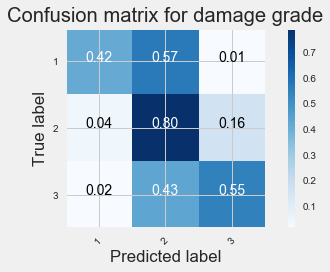

In [78]:
# Generate confusion matrix
damage_grades = [1,2,3]
plot_confusion_matrix(cnf_mtrx, damage_grades,
                          normalize=True,
                          title='Confusion matrix for damage grade')